## Contexte

Le CNN_1 est une version classique d'un CNN.

Son entrainement sur le jeu de données a donnée des résultats satisfaisants.

Cela est dû certainement :

* au choix de ses hyper-paramètres
* au nombre initial des photos dans le jeu de données
* à l'utilisation de l'augmentation du jeu d'image par ImageDataGenerator

Dans le CNN précédent le nombre d'epochs a été choisi assez faible pour des soucis évident de ressources système limitées. 

Malgré cela le CNN s'est bien comporté.

Nous pouvons constater que :

* Les résultats ont rapidement convergé vers des scores très satisfaisants, tant pour le jeu d'entrainement que pour le jeu de test.
* Un overfitting semble être présent tout du long du déroulé des ephochs : cet overfitting n'est pas énorme et devrait minimisé rapidement.
* Le nombre d'ephoch choisi précédement semble être insuffisant. Même si les résultats dépassent les 80% pour le jeu de test, la courbe d'apprentissage semble vouloir continuer sa progression au delà du nombre des epochs utilisé : au moins pour la courbe d'apprentissage correspondant au jeu d'entrainement.


## Objectif

Au cours de cette itération, il prévu d'essayer de :

* Diminuer le overtiffing, voire l'annuler
* Optimiser la courbe d'apprentissage, même si les résultats sont déjà assez satisfaisants, pour minimiser le nombre d'epochs à réaliser
* Essayer d'atteindre une convergence vers un maximum de la courbe d'apprentissage

Vu le temps d'entrainement d'un CNN, ces trois points seront implémentés ensembles.

En effet, les techniques à mettre en oeuvre, et aussi leur résultats respectifs, sont relativement connues pour pouvoir être testées ensembles.


In [1]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from lib import ressources as res
racine = os.path.abspath(os.path.realpath(res.dir_root))


In [2]:
# Import des librairies

# initialisation du CNN de manière séquentielle et non en graphe
from keras.models import Sequential

# les vidéos sont en 3D, on ajoute une dimension supplémentaire qui est le temps
# étape de convolution -> 2D car image
from keras.layers import Conv2D

# étape de max pooling
from keras.layers import MaxPooling2D

# étape de flatten
from keras.layers import Flatten

# couches du CNN
from keras.layers import Dense

# CNN optimization : Dropout added to avoid overfiting
from keras.layers import Dropout

In [3]:
# Le CNN est initialisé en mode séquentiel

classifier = Sequential()

In [4]:
# Conv2D -> couche de convolution
# Pour des raisons de limitation ressources système, les photo sont converties en 128 * 128

classifier.add(Conv2D(filters = 64, kernel_size = (3, 3), strides = 1, input_shape = (128, 128, 3), activation = 'relu'))

In [5]:
# couche : Max pooling

classifier.add(MaxPooling2D(pool_size = (2, 2)))

Amélioration de la détection de features du CNN par l'ajout d'une couche de convolution

L'ajout d'une couche de convolution implique l'ajout d'une couche Max Pooling

In [6]:
# Conv2D -> couche de convolution

classifier.add(Conv2D(filters = 32, kernel_size = (3, 3), strides = 1, activation = 'relu'))

# couche : Max pooling

classifier.add(MaxPooling2D(pool_size = (2, 2)))

In [7]:
# Couche : Flattening

classifier.add(Flatten())

Le overfitting est traité par l'ajout d'une couche Dropout après la couche Dense

In [8]:
# Couche : Full connection

classifier.add(Dense(units = 128, activation = 'relu'))

classifier.add(Dropout(0.3))

La classification est améliorée par l'ajout d'une couche Dense

Une couche Dropout est ajoutée ensuite.

In [9]:
classifier.add(Dense(units = 64, activation = 'relu'))

classifier.add(Dropout(0.3))

In [10]:
# Couche de sortie

classifier.add(Dense(units = 38, activation = 'softmax'))

In [11]:
# compilation du CNN

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [12]:
# entrainement du CNN

# augmentation du jeu d'images
from keras.preprocessing.image import ImageDataGenerator


# préparation du traitement de génération de nouvelles images pour le jeu d'entrainement
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# préparation du traitement de génération de nouvelles images pour le jeu de test : l'échelle des valeurs est normalisées
test_datagen = ImageDataGenerator(rescale = 1./255)

# traitement des images du jeu d'entrainement
training_set = train_datagen.flow_from_directory(res.dir_dataset_train,
                                                 target_size = (128, 128),
                                                 batch_size = 280,
                                                 class_mode = 'categorical')

# traitement des images du jeu de test
test_set = test_datagen.flow_from_directory(res.dir_dataset_valid,
                                            target_size = (128, 128),
                                            batch_size = 70,
                                            class_mode = 'categorical')



Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


Le nombre d'epochs est augmenté pour vérifier la convergeance vers un maximum pour les résultats

In [13]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_step = test_set.n // test_set.batch_size

# fit_generator -> entraine le CNN et effectue le test aussi et mesure la performance
training_history = classifier.fit_generator(training_set,
                         steps_per_epoch = steps_per_epoch,
                         epochs = 40,
                         validation_data = test_set,
                         validation_steps = validation_step)
                         

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
251/251 [==============================] - 938s 4s/step - loss: 2.6364 - accuracy: 0.2646 - val_loss: 1.5969 - val_accuracy: 0.5192
Epoch 2/40
251/251 [==============================] - 862s 3s/step - loss: 1.6794 - accuracy: 0.5003 - val_loss: 1.4633 - val_accuracy: 0.5695
Epoch 3/40
251/251 [==============================] - 862s 3s/step - loss: 1.3977 - accuracy: 0.5775 - val_loss: 1.0453 - val_accuracy: 0.6767
Epoch 4/40
251/251 [==============================] - 861s 3s/step - loss: 1.2240 - accuracy: 0.6280 - val_loss: 0.9555 - val_accuracy: 0.7081
Epoch 5/40
251/251 [==============================] - 868s 3s/step - loss: 1.1095 - accuracy: 0.6628 - val_loss: 0.9177 - val_accuracy: 0.7152
Epoch 6/40
251/251 [==============================] - 869s 3s/step - loss: 1.0043 - accuracy: 0.6922 - val_loss: 0.8963 - val_accuracy: 0.7245
Epoch 7/40
251/251 [==============================] - 871s 3s/step

In [26]:
# import numpy as np
# import tensorflow as tf
from tensorflow import keras

path_cnn = res.dir_dataset + '_cnn_2.save'
# print(path_cnn)

classifier.save(path_cnn);

INFO:tensorflow:Assets written to: C:\Users\NOEL\dev\python\dataset\new-plant-diseases-dataset_cnn_2.save\assets


In [15]:
# les scores obtenus pendant l'entrainement sont lus
train_acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']

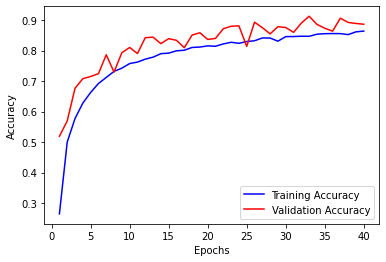

In [19]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt # Pour l'affichage d'images
from matplotlib import cm # Pour importer de nouvelles cartes de couleur
%matplotlib inline

# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Courbe de la précision sur l'échantillon d'entrainement
plt.plot(np.arange(1 , 41, 1),
         training_history.history['accuracy'],
         label = 'Training Accuracy',
         color = 'blue')

# Courbe de la précision sur l'échantillon de validation
plt.plot(np.arange(1 , 41, 1),
         training_history.history['val_accuracy'], 
         label = 'Validation Accuracy',
         color = 'red')

# Affichage de la légende
plt.legend()

# Affichage de la figure
plt.show()

## Conclusion

Afin de mesurer précisemment les améliorations de chacune des modifications, il aurait été préférable de réaliser après chaque modification, un entrainement du CNN et donc lors de :

* l'ajout des couches Dropout
* l'ajout des couches de Convolution et des couches de Max Pooling
* l'ajout de la couche Dense

Mais pour pouvoir procéder de cette manière, il aurait été nécessaire de disposer des ressources système supplémentaire : serveur avec plusieurs GPU par exemple.

Néanmois, on note, par rapport au CNN précédent, que les résultats sont meilleurs. La courbe d'apprentissage est aussi plus régulière dans sa montée en performance.

Le overfitting a été résorbé : cela a principalement été dû par l'ajout des couches Dropout qui déconnectent particiellement et de manière aléatoire les neurones entres eux. 

Egalement, l'ajout d'une couche de Convolution et de Max Pooling a amélioré la détection des features et a donc rendu cette courbe d'apprentissage plus régulière.

Par contre, le CNN ne semble pas avoir atteint son score maximum : en effet et malgré l'utilisation d'un nombre d'epochs égal à 40, la courbe d'apprentissage semble vouloir continuer sa progresseion au dela des 40 epochs.
